<a href="https://colab.research.google.com/github/CeciliaKimura/time-series/blob/main/Time_Series_Forecasting_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting with Prophet (Facebook)**

## Previsão do Preço da Soja


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importação das bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = 12, 7

Populating the interactive namespace from numpy and matplotlib


**Importação da base**

Utilizei a base Indicador da Soja CEPEA/ESALQ disponível em https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx

In [3]:
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

**Visualização dos dados**

In [4]:
df.head()

,Data,Preco_Dolar
0,01/2011,29.61
1,02/2011,29.54
2,03/2011,27.92
3,04/2011,27.98
4,05/2011,27.86


In [5]:
df.dtypes

Data            object
Preco_Dolar    float64
dtype: object

Transformar a coluna 'Data' para o formato datetime

In [6]:
df['Data'] = pd.to_datetime(df['Data'], format='%m/%Y')
df.dtypes

Data           datetime64[ns]
Preco_Dolar           float64
dtype: object

In [7]:
df.head()

,Data,Preco_Dolar
0,2011-01-01,29.61
1,2011-02-01,29.54
2,2011-03-01,27.92
3,2011-04-01,27.98
4,2011-05-01,27.86


Fazer uma breve análise dos dados

In [8]:
df.describe()

,Preco_Dolar
count,120.000000
mean,24.627750
std,5.219108
min,17.870000
25%,20.270000
50%,22.480000
75%,28.475000
max,40.900000


Agora que estamos com o formato correto dos dados vamos plotar a série temporal para já termos os primeiros insights de sazonalidade, outliers, tendêcias...

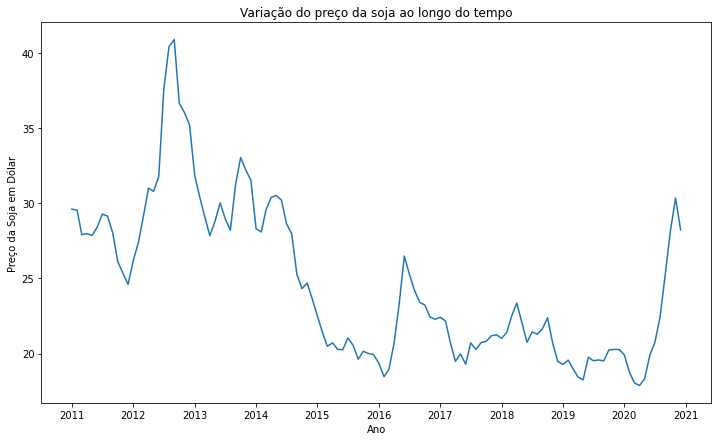

In [9]:
plt.plot('Data', 'Preco_Dolar', data=df)
plt.title('Variação do preço da soja ao longo do tempo')
plt.xlabel('Ano')
plt.ylabel('Preço da Soja em Dólar')
plt.show()

Analisando o gráfico podemos verificar uma tendência de decaimento nos preços ao longo dos anos, aparentemente também parece existir um padrão que se repete a cada 4 anos.

Vamos utilizar o Prophet para a análise de séries temporais. Abaixo descrição da própria página do Facebook Prophet https://facebook.github.io/prophet/docs/quick_start.html

**Facebook Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook's Core Data Science team. 

**Importação do Prophet**

In [10]:
from fbprophet import Prophet

O prophet trabalha com duas colunas:

*   ds: features temporais
*   y: valores a serem preditos

Então vamos renomer nossas colunas para a nomenclatura padrão







In [11]:
df.columns = ['ds', 'y']

In [12]:
df.tail()

,ds,y
115,2020-08-01,22.44
116,2020-09-01,25.30
117,2020-10-01,28.14
118,2020-11-01,30.35
119,2020-12-01,28.23


**Dividir os dados entre treino e teste**

In [13]:
train = df[df['ds'] < "2020-01-01"]
test = df[df['ds'] >= "2020-01-01"]
train.shape, test.shape

((108, 2), (12, 2))

In [14]:
train.head()

,ds,y
0,2011-01-01,29.61
1,2011-02-01,29.54
2,2011-03-01,27.92
3,2011-04-01,27.98
4,2011-05-01,27.86


In [15]:
test.head()

,ds,y
108,2020-01-01,19.91
109,2020-02-01,18.74
110,2020-03-01,18.04
111,2020-04-01,17.87
112,2020-05-01,18.33


In [16]:
test.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [17]:
test.tail(30)

,ds,y
108,2020-01-01,19.91
109,2020-02-01,18.74
110,2020-03-01,18.04
111,2020-04-01,17.87
112,2020-05-01,18.33
113,2020-06-01,19.89
114,2020-07-01,20.74
115,2020-08-01,22.44
116,2020-09-01,25.30
117,2020-10-01,28.14


Antes de rodar o modelo Prophet vamos criar uma baseline para servir de comparação dos resultados

**Baseline**

Vamos usar como baseline o preço do período anterior

In [18]:
# obtem todos od dados do treino 
history = [x for x in train['y']]

# cria lista de previsões
predictions = list()

# aplicando o modelo naive
for i in range(len(test)):
  
  # valor_predito recebe o último valor do conjunto de treino
  valor_predito = history[-1]
  
  # a primeira previsão é o último valor do conjunto de treino
  predictions.append(valor_predito)
  
  # valor real recebe o valor atual do teste.
  valor_real = test['y'].values[i]
  
  # adiciona o valor real para a lista de historico
  history.append(valor_real)
  
  # imprime valor predito e valor real..
  print('Valor Predito=%.3f, Valor Esperado=%.3f' % (valor_predito, valor_real))

Valor Predito=20.270, Valor Esperado=19.910
Valor Predito=19.910, Valor Esperado=18.740
Valor Predito=18.740, Valor Esperado=18.040
Valor Predito=18.040, Valor Esperado=17.870
Valor Predito=17.870, Valor Esperado=18.330
Valor Predito=18.330, Valor Esperado=19.890
Valor Predito=19.890, Valor Esperado=20.740
Valor Predito=20.740, Valor Esperado=22.440
Valor Predito=22.440, Valor Esperado=25.300
Valor Predito=25.300, Valor Esperado=28.140
Valor Predito=28.140, Valor Esperado=30.350
Valor Predito=30.350, Valor Esperado=28.230


**A métrica de erro selecionada foi a RMSLE (root mean squared log error)**

RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation.Thi is especially useful for business cases where the underestimation of the target variable is not acceptable but overestimation can be tolerated.
In the case of RMSE, the presence of outliers can explode the error term to a very high value. But, in the case of RMLSE the outliers are drastically scaled down therefore nullifying their effect.
RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value Increases in magnitude if the scale of error increases.


In [19]:
from pandas import DataFrame

from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(test['y'], DataFrame(predictions,columns=['ypred'])))

0.06637602443446745

Essa métrica pode ser interpretada como 6.63% de erro entre os valores preditos e reais.




Para melhor visualização vamos plotar um gráfico comparando os valores estipulados na baseline com os valores reais do período de teste

In [20]:
Xtrain, ytrain = train.drop(['y'], axis=1).reset_index(drop=True), train['y'].reset_index(drop=True)
Xtest, ytest = test.drop(['y'], axis=1).reset_index(drop=True), test['y'].reset_index(drop=True)

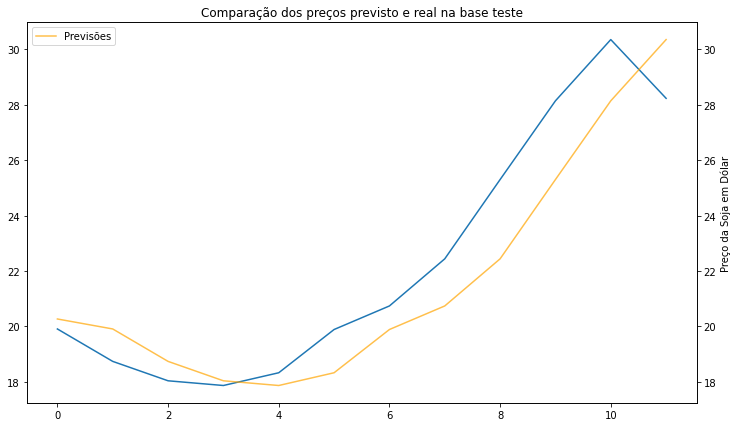

In [21]:
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(predictions, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Como podemos observar pelo gráfico e pelo erro, a utilização do valor do período anterior para previsão do próximo período parece ser um bom "chute" inicial. O objetivo agora é criar um modelo que consiga bater essa baseline. Vamos testar o uso do Prophet, procedimento criado pelo Facebook para previsão de time series.

**Primeiro passo é instanciar um objeto Prophet**




In [22]:
m = Prophet()

**Criar o modelo**

Vamos agora gerar um modelo em cima da nossa base de treino

In [23]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


A partir do modelo treinado podemo prever períodos futuros, sendo o perído definido pelo parâmetro frequência, que utiliza os mesmos padrões de frequência do pandas https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [24]:
future = m.make_future_dataframe(periods = 12, freq='MS')

In [25]:
future

,ds
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01
...,...
115,2020-08-01
116,2020-09-01
117,2020-10-01
118,2020-11-01


Como podemos observar o método 'Prophet.make_future_dataframe' cria um dataframe com as datas que queremos fazer as previsões. Agora utilizamos o método 'predict' para calcular e atribuir o valor predito para cada data, assim como seus intervalos de incerteza. 

**Previsões**

In [26]:
forecast = m.predict(future)

In [27]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,31.616209,26.564618,34.804599,31.616209,31.616209,-1.052267,-1.052267,-1.052267,-1.052267,-1.052267,-1.052267,0.0,0.0,0.0,30.563942
1,2011-02-01,31.501849,26.088763,34.358476,31.501849,31.501849,-1.156138,-1.156138,-1.156138,-1.156138,-1.156138,-1.156138,0.0,0.0,0.0,30.345711
2,2011-03-01,31.398556,26.642753,34.626225,31.398556,31.398556,-0.904860,-0.904860,-0.904860,-0.904860,-0.904860,-0.904860,0.0,0.0,0.0,30.493696
3,2011-04-01,31.284196,26.538835,34.474898,31.284196,31.284196,-0.626895,-0.626895,-0.626895,-0.626895,-0.626895,-0.626895,0.0,0.0,0.0,30.657301
4,2011-05-01,31.173525,26.829170,34.791065,31.173525,31.173525,-0.412852,-0.412852,-0.412852,-0.412852,-0.412852,-0.412852,0.0,0.0,0.0,30.760673


In [28]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2020-08-01,18.290439,14.138974,22.459998
116,2020-09-01,18.144981,13.705387,22.214738
117,2020-10-01,17.590668,13.616240,21.606475
118,2020-11-01,17.203006,13.222992,21.198761
119,2020-12-01,16.862642,12.849108,21.081202


**Plotar gráficos de forecast e dos componentes**

O método 'plot' plota os dados de forecast, incluindo os dados históricos usados para treino.

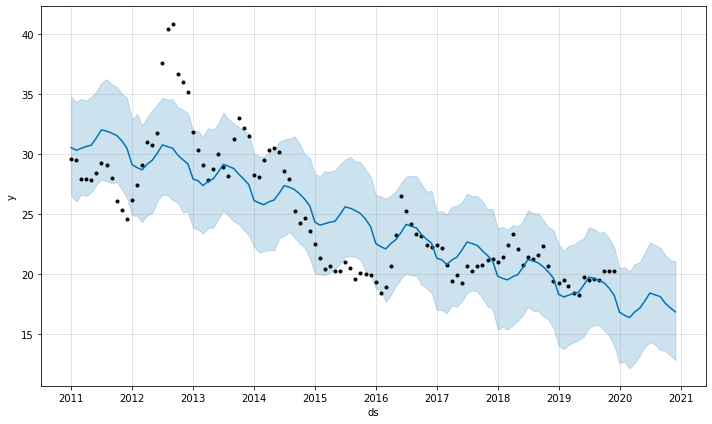

In [29]:
fig1 = m.plot(forecast)

O método 'plot_components' plota os componetes de tendência e sazonalidade (anual, mensal, diária, feriados etc) da time series.

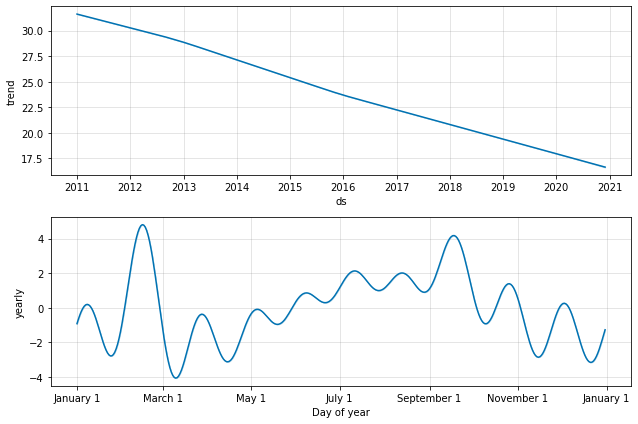

In [30]:
fig2 = m.plot_components(forecast)

In [31]:
len(forecast['yhat'])

120

O Prophet utilizou automaticamente apenas a sazonalidade anual no modelo, acredito que a sazonalidade mensal e a quadrianual também são importantes e vou adicioná-las manualmente.

**Adicionar uma sazonalidade customizada**

Vou adicionar a sazonalidade mensal e a quadrianual






In [32]:
m = Prophet()
m.add_seasonality(name='monthly', period=22, fourier_order=5)
m.add_seasonality(name='4years', period=1056, fourier_order=10)

In [33]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods = 12, freq='MS')

**Previsões**

In [35]:
forecast = m.predict(future)

In [36]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2020-08-01,21.828437,20.142807,23.433606
116,2020-09-01,22.776589,21.043864,24.436719
117,2020-10-01,28.740384,26.918119,30.404193
118,2020-11-01,30.247508,28.588981,31.961524
119,2020-12-01,29.583783,27.916801,31.327671


**Plotar gráficos de forecast e dos componentes**

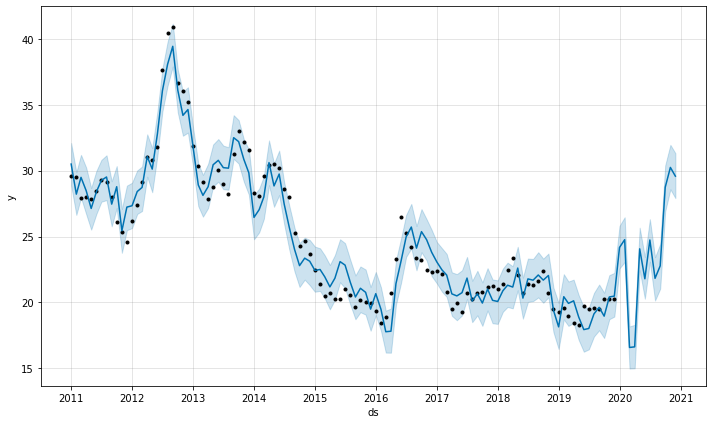

In [37]:
fig1 = m.plot(forecast)

Podemos observar que os dados ficam melhor ajustados

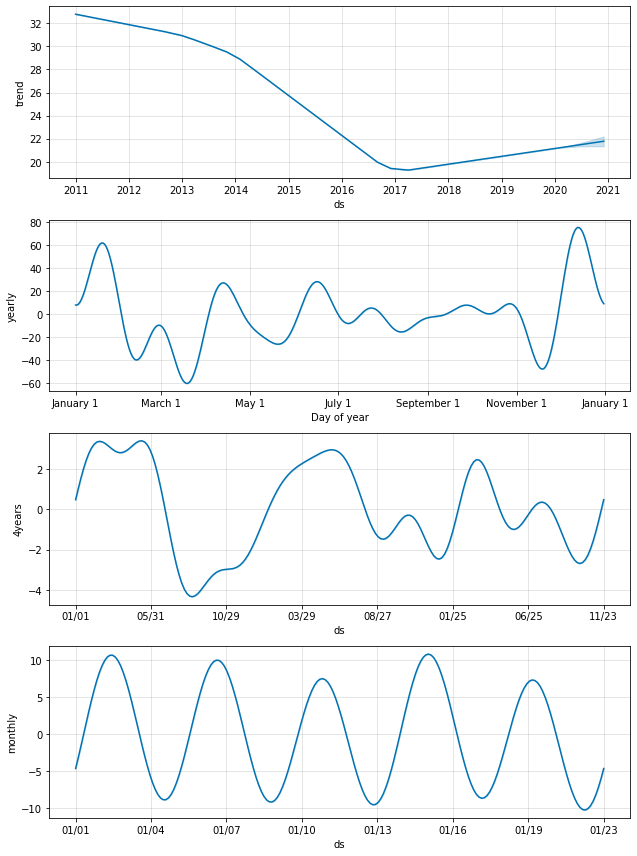

In [38]:
fig2 = m.plot_components(forecast)

# Validando o modelo com Prophet

Aplicando o modelo do prophet à base de teste

In [39]:
test_forecast = m.predict(test)

Imprimir as saidas

In [40]:
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,24.170965,22.373888,25.856320
1,2020-02-01,24.762352,23.091629,26.399457
2,2020-03-01,16.579941,14.842676,18.298144
3,2020-04-01,16.627374,15.049316,18.411957
4,2020-05-01,24.067033,22.447363,25.760811
5,2020-06-01,21.793923,20.101240,23.376586
6,2020-07-01,24.737937,22.870634,26.402223
7,2020-08-01,21.828437,20.048993,23.501406
8,2020-09-01,22.776589,21.136116,24.503338
9,2020-10-01,28.740384,27.187156,30.359697


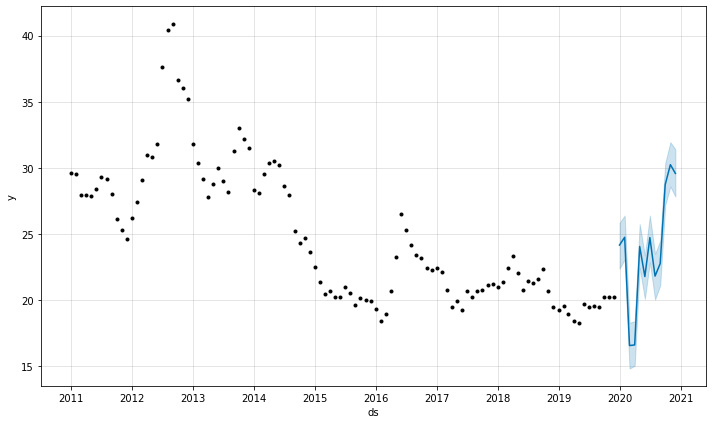

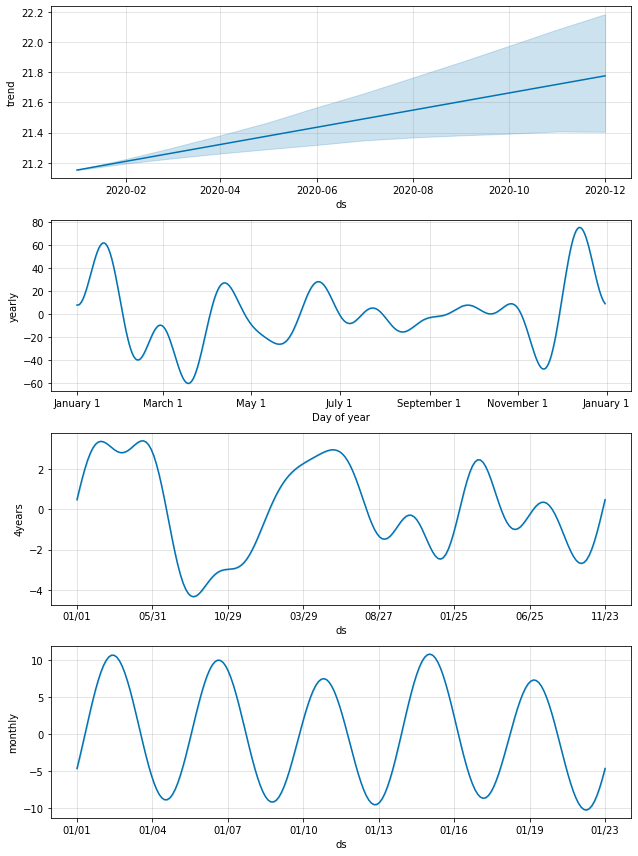

In [41]:
fig1 = m.plot(test_forecast)
fig2 = m.plot_components(test_forecast)

Cálculo do erro (RMSLE)

In [42]:
from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(test['y'], test_forecast.yhat))

0.13943377445570887

Esse erro pode ser interpretado como 13.94% de erro entre os valores preditos e os reais.

Vamos plotar o gráfico de comparação




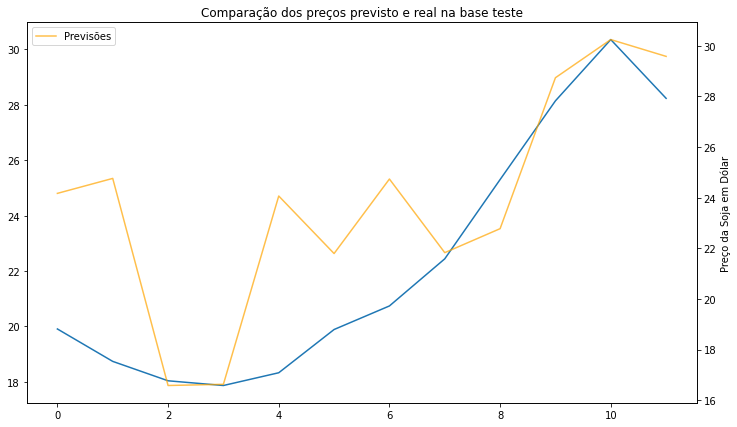

In [43]:
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(test_forecast.yhat, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Analisando o erro e o gráfico, podemos concluir que o modelo ficou bem longe de bater a baseline e portanto precisa ser melhorado. Para isso podemos usar diferentes períodos de tempo, verificar se históricamente algum período deveria ser desconsiderado, etc. 

Além disso outra técnicas de modelagem podem ser utilizadas e talvez se adequem melhor a essa série temporal, como as técnicas mais clássicas ARIMA, SARIMA, além de outras técnicas como Random Forest, LightGBM, Redes Neurais entre outras.

**Adicionando sazonalidades customizadas**

Sazonalidade mensal

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds      y
96  2019-01-01  19.27
97  2019-02-01  19.56
98  2019-03-01  19.00
99  2019-04-01  18.43
100 2019-05-01  18.25
101 2019-06-01  19.75
102 2019-07-01  19.52
103 2019-08-01  19.57
104 2019-09-01  19.51
105 2019-10-01  20.24
106 2019-11-01  20.27
107 2019-12-01  20.27
RMSLE: 0.197


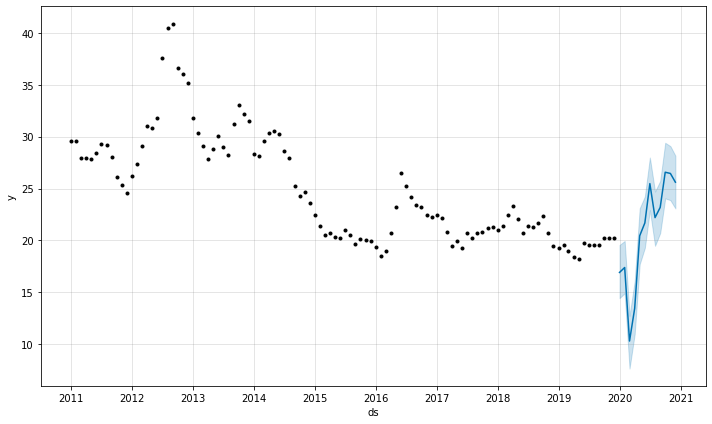

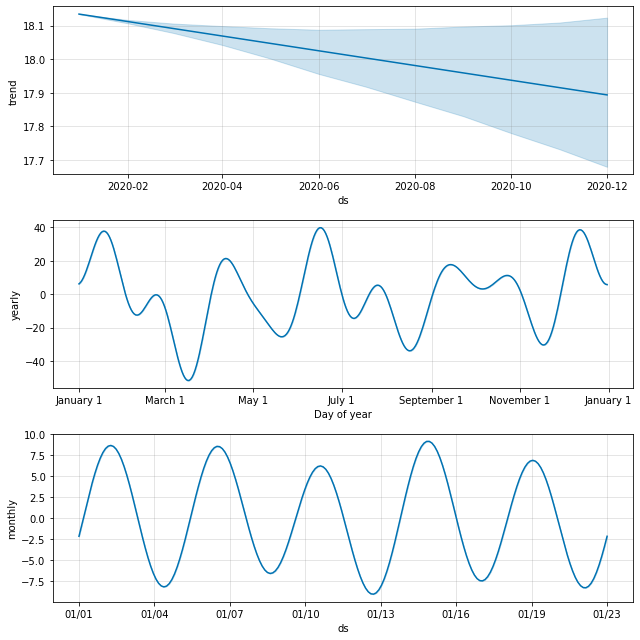

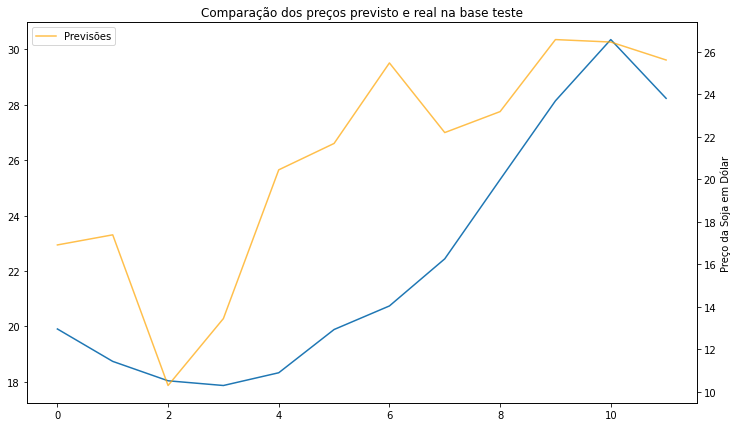

In [44]:
# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

# Separar os dados de teste (12 meses)
train = df.drop(df.index[-12:])
print(train.tail(12))

# Instanciar um objeto Prophet
m = Prophet()
m.add_seasonality(name='monthly', period=22, fourier_order=5)

# Treinar o modelo
m.fit(train)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2020-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

# Calcular o erro entre o previsto e o real
ytest = df['y'][-12:].values
ypred = forecast['yhat'].values
rmsle = np.sqrt(mean_squared_log_error(ytest, ypred))
print('RMSLE: %.3f' % rmsle)

# Plotar o gráfico comparativo entre os valores reais e previstos
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(ypred, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Sazonalidade quadrianual

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds      y
96  2019-01-01  19.27
97  2019-02-01  19.56
98  2019-03-01  19.00
99  2019-04-01  18.43
100 2019-05-01  18.25
101 2019-06-01  19.75
102 2019-07-01  19.52
103 2019-08-01  19.57
104 2019-09-01  19.51
105 2019-10-01  20.24
106 2019-11-01  20.27
107 2019-12-01  20.27
RMSLE: 0.369


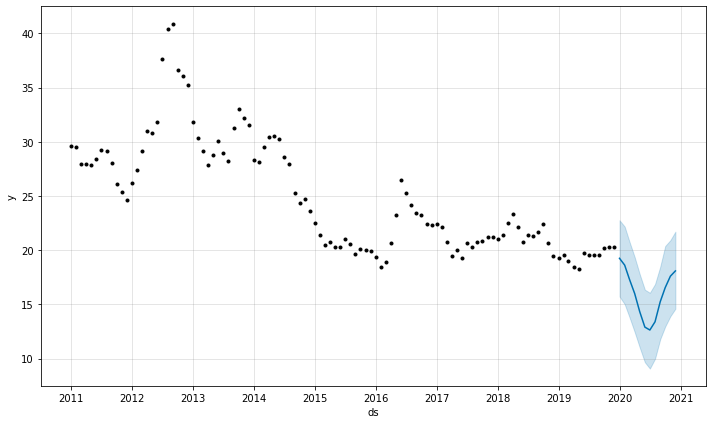

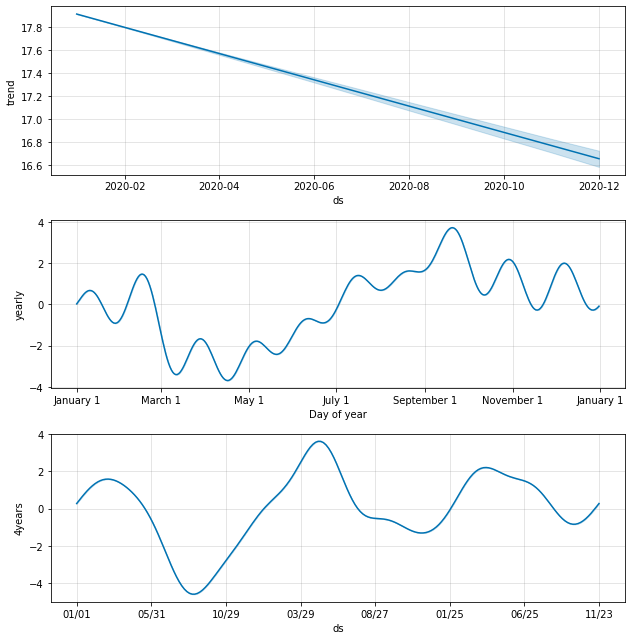

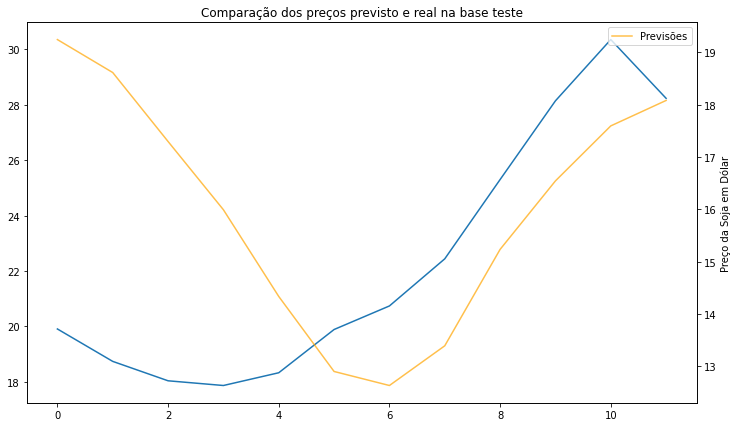

In [45]:
# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

# Separar os dados de teste (12 meses)
train = df.drop(df.index[-12:])
print(train.tail(12))

# Instanciar um objeto Prophet
m = Prophet()
m.add_seasonality(name='4years', period=1056, fourier_order=10)

# Treinar o modelo
m.fit(train)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2020-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

# Calcular o erro entre o previsto e o real
ytest = df['y'][-12:].values
ypred = forecast['yhat'].values
rmsle = np.sqrt(mean_squared_log_error(ytest, ypred))
print('RMSLE: %.3f' % rmsle)

# Plotar o gráfico comparativo entre os valores reais e previstos
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(ypred, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

**Alterando o período de treino**

Reduzindo o período de treino para apenas 1 ano anterior ao período de teste

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds      y
96  2019-01-01  19.27
97  2019-02-01  19.56
98  2019-03-01  19.00
99  2019-04-01  18.43
100 2019-05-01  18.25
101 2019-06-01  19.75
102 2019-07-01  19.52
103 2019-08-01  19.57
104 2019-09-01  19.51
105 2019-10-01  20.24
106 2019-11-01  20.27
107 2019-12-01  20.27


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


RMSLE: 0.154


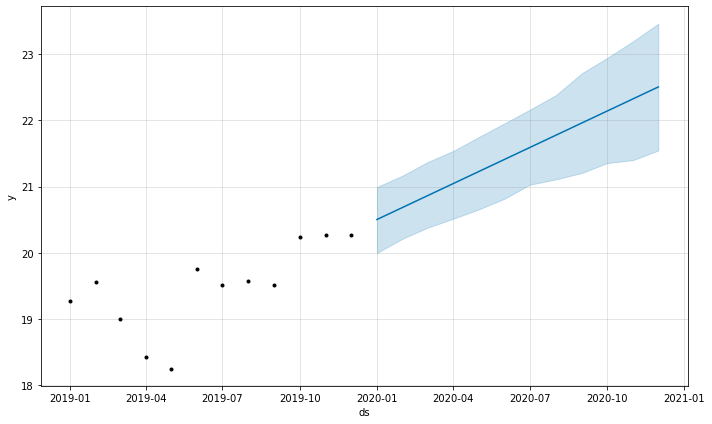

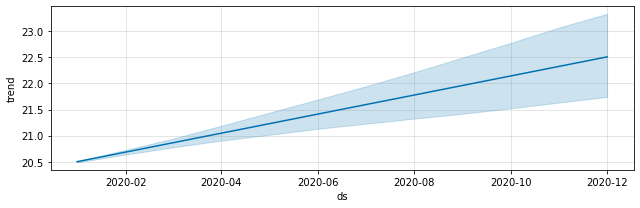

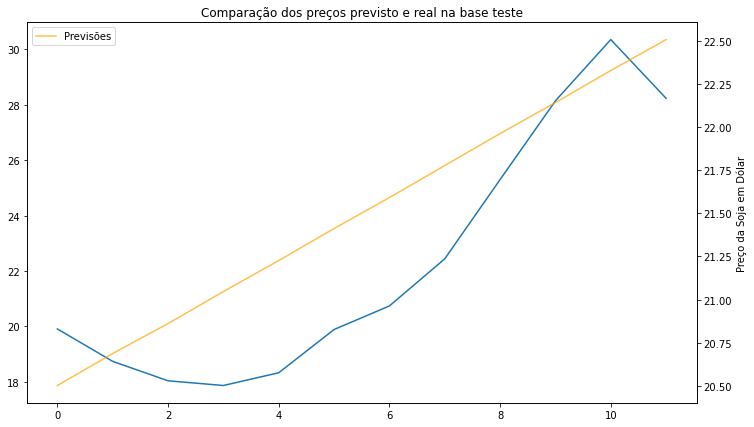

In [46]:
# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

# Definir o perído de treino
df = df[(df['ds'] >= "2019-01") & (df['ds'] <= "2020-12")]

# Separar os dados de teste (12 meses)
train = df.drop(df.index[-12:])
print(train.tail(12))

# Instanciar um objeto Prophet
m = Prophet()

# Treinar o modelo
m.fit(train)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2020-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

# Calcular o erro entre o previsto e o real
ytest = df['y'][-12:].values
ypred = forecast['yhat'].values
rmsle = np.sqrt(mean_squared_log_error(ytest, ypred))
print('RMSLE: %.3f' % rmsle)

# Plotar o gráfico comparativo entre os valores reais e previstos
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(ypred, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

O erro ficou em '15.4%, ainda bem longe da baseline. Além disso pelo gráfico podemos verificar que a previsão foi bem ruim na maioria dos meses. O que era de se esperar pois, analisando a série histórica, podemos ver que o comportamento do ano 2019 foi bem diferente do ano 2020.

***O modelo que apresentou melhor resultado foi o com as sazonalidades quadrianual e mensal customizadas. Ainda assim o erro é maior (13.94%) que o da baseline (6.63%).***

# Criar um "Out-of-Sample Forecast"

**Previsão do preço da soja para o ano de 2021**

Utilizei o modelo com as sazonalidades quadrianual e mensal customizadas, porém como pudemos observar essa série temporal não parece seguir tendências e sazonalidades claras, outros fatores como mercado, crises e acordos comercias parecem ter um grande impacto e não conseguem ser modelados por essa abordagem do Prophet. Teríamos que escolher uma abordagem multivariada, talvez modelos de árvore de decisão e redes neurais ou a combinação de modelos (ensemble) poderiam explicar melhor esses fatores.



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds       yhat  yhat_lower  yhat_upper
0  2021-01-01  26.158997   24.314465   28.057940
1  2021-02-01  25.899960   24.185330   27.776983
2  2021-03-01  19.617075   17.604512   21.564165
3  2021-04-01  17.455194   15.512319   19.192335
4  2021-05-01  21.775186   19.833063   23.659102
5  2021-06-01  23.008238   21.132933   24.876036
6  2021-07-01  25.694001   23.874639   27.547823
7  2021-08-01  25.629499   23.864459   27.448031
8  2021-09-01  24.817745   22.997175   26.625192
9  2021-10-01  26.742404   24.912104   28.628153
10 2021-11-01  26.851134   24.904906   28.803151
11 2021-12-01  24.004174   22.166613   26.009543


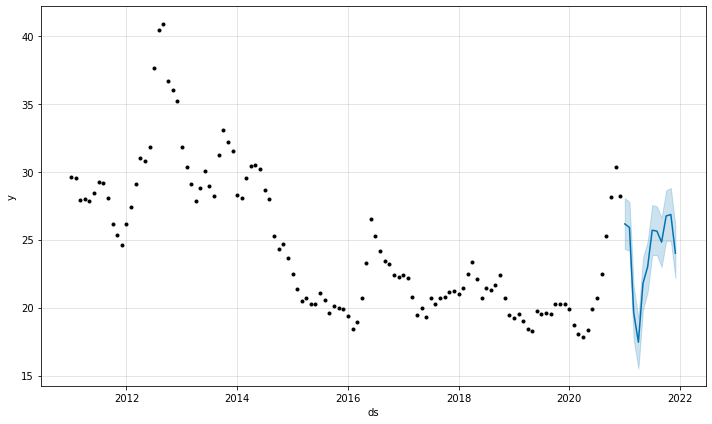

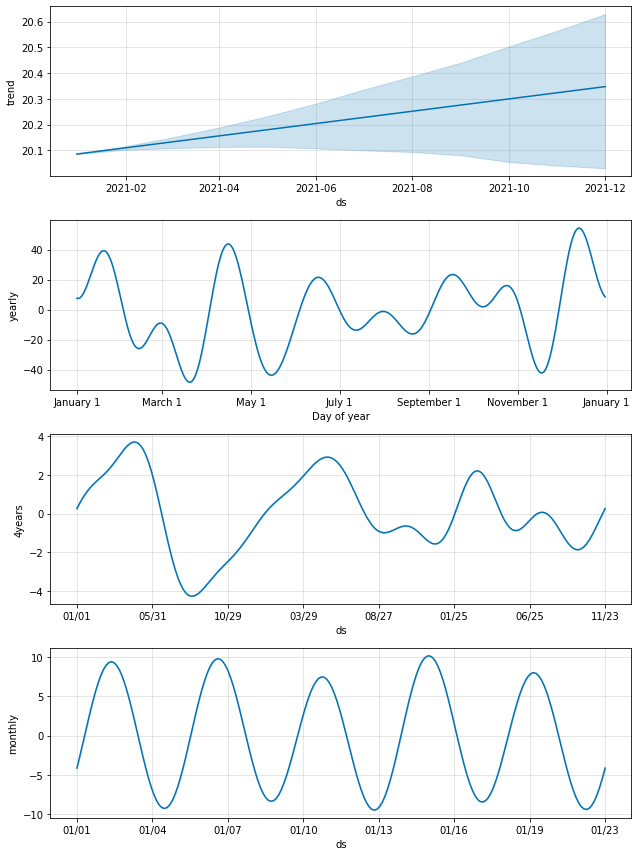

In [47]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

# # Instanciar um objeto Prophet
m = Prophet()
m.add_seasonality(name='monthly', period=22, fourier_order=5)
m.add_seasonality(name='4years', period=1056, fourier_order=10)

# Treinar o modelo
m.fit(df)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)

# Resumo do forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plotar o forecast e os componentes
fig3 = m.plot(forecast)
fig4 = m.plot_components(forecast)